In [ ]:
#Normal method
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils

cap=cv2.VideoCapture("./Fluo-N2DL-HeLa/Sequence 1/t%03d.tif")

ret, frame1=cap.read()
ret, frame2=cap.read()


while cap.isOpened():
    
    if ret == True:
        #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        img_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
        img=frame1

        ret,thresh=cv2.threshold(img_gray,129,255,cv2.THRESH_BINARY)
        #blured = cv2.medianBlur(thresh, 7)
        #thresh= cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
        #element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
        #b=cv2.erode(thresh,element)

        blured = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
        #blured = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)
        #blured = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=2)
        contours = cv2.findContours(blured,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)  
        image = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)
        #cv2.drawContours(img_gray,contours[1],-1,(0,255,0),3)
        for contour in contours[1]:
            (x,y,w,h) = cv2.boundingRect(contour)
            if cv2.contourArea(contour)<40:
                continue
            cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(image, "Number of cells: {}".format(len(contours[1])), (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1 )
        
        
        cv2.imshow('frame',image)
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break
        frame1 = frame2
        ret, frame2 = cap.read()
        
        
    else:
        break
    
    
cap.release()

In [ ]:
#watershed
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import imutils

cap=cv2.VideoCapture("./Fluo-N2DL-HeLa/Sequence 1/t%03d.tif")

ret, frame1=cap.read()
ret, frame2=cap.read()


while cap.isOpened():
    
    if ret == True:
        #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        img=frame1
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret,thresh=cv2.threshold(img_gray,129,255,cv2.THRESH_BINARY)
        thresh= cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

        D = ndimage.distance_transform_edt(thresh)
        localMax = peak_local_max(D, indices=False, min_distance=15, labels=thresh)

        markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
        labels = watershed(-D, markers, mask=thresh)    
        image=img
        for label in np.unique(labels):
            # if the label is zero, we are examining the 'background'
            # so simply ignore it
            if label == 0:
                continue
            mask = np.zeros(thresh.shape, dtype="uint8")
            mask[labels == label] = 255
            # detect contours in the mask and grab the largest one
            cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
                cv2.CHAIN_APPROX_SIMPLE)

            cnts = imutils.grab_contours(cnts)
            
            c = max(cnts, key=cv2.contourArea)
            # draw a circle enclosing the object
            (x,y,w,h) = cv2.boundingRect(c)
            if cv2.contourArea(c)<40:
                continue
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
            #cv2.putText(image, "{}".format(label), (int(x) - 10, int(y)),
                #cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
            cv2.putText(img, "Number of cells: {}".format(len(np.unique(labels))), (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1 )
        
        
        cv2.imshow('frame',img)
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break
        frame1 = frame2
        ret, frame2 = cap.read()
        
        
    else:
        break
    
    
cap.release()

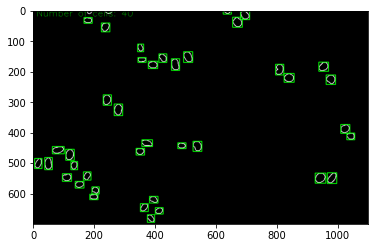

In [2]:
#ridge segmentation
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from sklearn.preprocessing import normalize

def detect_ridges(gray, sigma=1.0):
    H_elems = hessian_matrix(gray, sigma=sigma, order='rc')
    maxima_ridges, minima_ridges = hessian_matrix_eigvals(H_elems)
    return maxima_ridges, minima_ridges

img = cv2.imread("./Fluo-N2DL-HeLa/Sequence 1/t010.tif")
img_copy=img.copy()
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#img_gray=cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
#plt.imshow(img_gray,cmap='gray')
element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
ret,thresh=cv2.threshold(img_gray,129,255,cv2.THRESH_BINARY)
thresh=cv2.erode(thresh,element)
blured = cv2.medianBlur(thresh, 5)

img=blured
#img = cv2.imread(src_path, 0) # 0 imports a grayscale
if img is None:
    raise(ValueError(f"Image didn\'t load. Check that '{src_path}' exists."))

a, b = detect_ridges(img, sigma=1)
a=np.array(a)
Imax = np.max(a)
Imin = np.min(a)
MAX = 255
MIN = 0
farina_cs = (a - Imin) / (Imax - Imin) * (MAX - MIN) + MIN      
a=farina_cs.astype("uint8")
#a=a*255
#a1=a.flatten()
#print(max(a1))
#a=a.astype('uint8')
#kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
#a= cv2.morphologyEx(a, cv2.MORPH_CLOSE, kernel, iterations=3)
#a = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
#plot_images(img, a, b)
re2, thresh2 = cv2.threshold(a, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
blured=thresh2

#blured=cv2.morphologyEx(blured, cv2.MORPH_CLOSE, kernel, iterations=2)
contours = cv2.findContours(blured,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 
blured = cv2.cvtColor(blured, cv2.COLOR_GRAY2RGB)
num=0
#cv2.drawContours(img_gray,contours[1],-1,(0,255,0),3)
for contour in contours[1]:
    num=num+1
    if num%2==0:
        continue
    
    (x,y,w,h) = cv2.boundingRect(contour)
    if cv2.contourArea(contour)<50:
        continue
    cv2.rectangle(blured, (x, y), (x+w, y+h), (0, 255, 0), 2)
cv2.putText(blured, "Number of cells: {}".format(round(len(contours[1])/2)), (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1 )

plt.imshow(blured,cmap='gray')
#cv2.imshow('img',blured)
#cv2.waitKey(0)
#cv2.destoryAllWindows()